In [165]:
import root_pandas
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np
import seaborn as sns

%matplotlib inline
sns.set()

In [134]:
df = root_pandas.read_root("degALL_looseChiUE_treeFlat_DSelector.root",
                          columns=["Mpi0","Meta","unusedEnergy","chiSq","AccWeight","weightASBS"])

In [135]:
df["weightBS"] = df["weightASBS"]/df["AccWeight"]

In [136]:
selectionVars=["unusedEnergy","chiSq"]
nSelectionVars=len(selectionVars)

discrimVars=["Mpi0","Meta"]
nDiscrimVars=len(discrimVars)

statNames=["sigYield","bkgYield","purity"]
nStats=len(statNames)

In [205]:
def buildSubplots(nColsPlot,nVars):
    nRows=int(nVars/nColsPlot)+int(nVars%nColsPlot>0)
    fig, axes = plt.subplots(nRows,nColsPlot,figsize=(16,nRows*6))
    axes=axes.flatten()
    return fig,axes

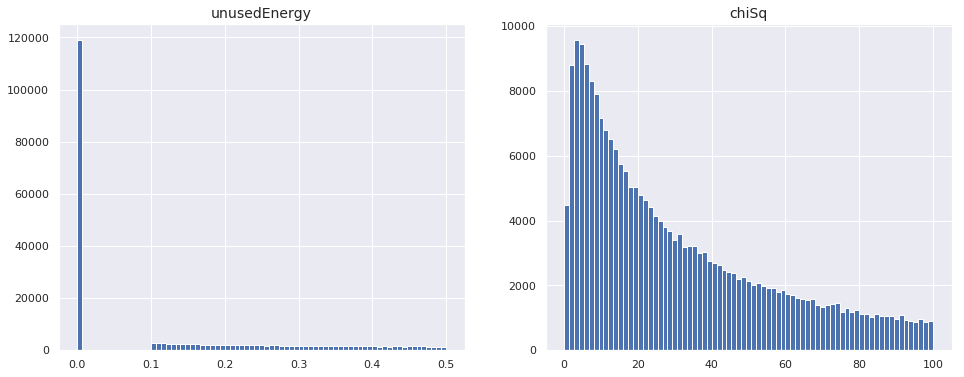

In [206]:
fig, axes=buildSubplots(2,nSelectionVars)
for iax, selectionVar in enumerate(selectionVars):
    df[selectionVar].hist(bins=75,weights=df.AccWeight,ax=axes[iax])
    axes[iax].set_title(selectionVar,size=14)

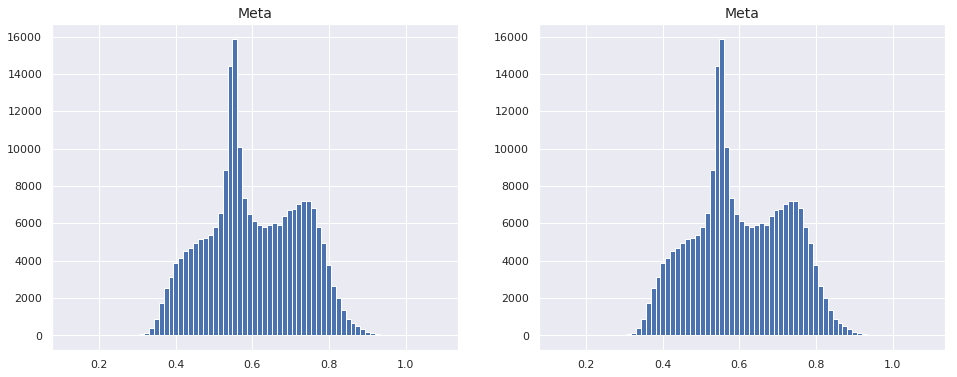

In [207]:
fig, axes=buildSubplots(2,nDiscrimVars)
for iax, discimVar in enumerate(discrimVars):
    df[discrimVar].hist(bins=75,weights=df.AccWeight,ax=axes[iax])
    axes[iax].set_title(discrimVar,size=14)

In [167]:
mins=[]
maxs=[]
for iVar, selectionVar in enumerate(selectionVars):
    maxs.append(df[selectionVar].max())
    mins.append(df[selectionVar].min())

In [168]:
def getThresholds():
    thresholds=[]
    selection=True
    for iVar, selectionVar in enumerate(selectionVars):
        criteria=np.random.uniform(mins[iVar],maxs[iVar])
        thresholds.append(criteria)
        selection = selection*(df[selectionVar] <= criteria)
    return thresholds, selection

In [169]:
def determineQuality():
    sigBool=df["weightBS"]==1
    bkgBool=(df["weightBS"]!=1) & (df["weightBS"]!=0)
    sigYield=df[sigBool*selection].weightASBS.sum()
    bkgYield=-1*df[bkgBool*selection].weightASBS.sum()
    purity=sigYield/(sigYield+bkgYield)
    return sigYield,bkgYield,purity

In [170]:
def convertDouble(var):
    return '{0:.2f}'.format(var)

In [208]:
def getDiagPlots():
    fig, axes=buildSubplots(2,nDiscrimVars)
    title=map(convertDouble,thresholds)
    title="\n".join([a+"< "+b for a,b in zip(selectionVars,title)])
    plt.suptitle(title,size=18)
    fig.subplots_adjust(top=0.8)
    for i,discrimVar in enumerate(discrimVars):
        df.loc[selection,discrimVar].hist(bins=75,ax=axes[i],weights=df.loc[selection,"AccWeight"])
        axes[i].set_title(discrimVar,size=14)

    statBox=map(convertDouble,stats)
    statBox="\n".join([a+":"+b for a,b in zip(statNames,statBox)])
    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    # place a text box in upper left in axes coords
    axes[0].text(0.6, 0.95, statBox, transform=axes[0].transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

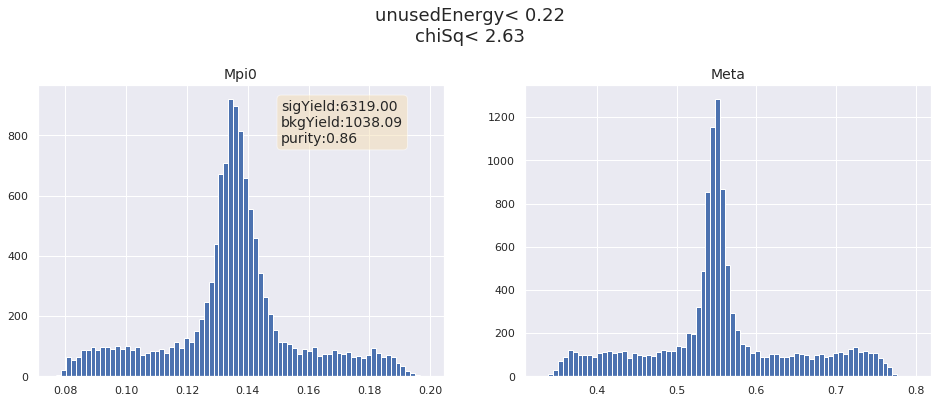

In [209]:
thresholds, selection = getThresholds()
stats = determineQuality()
getDiagPlots()

In [179]:
nPoints=500
statPoints=nSelectionVars+nStats
df_quality=np.zeros([nPoints,statPoints])
for i in range(nPoints):
    thresholds, selection = getThresholds()
    stats = determineQuality()
    df_quality[i]=np.array(thresholds+list(stats))
colNames=[a+"Thresh" for a in selectionVars]+statNames
df_quality=pd.DataFrame(df_quality, columns=colNames)

In [227]:
def plotMesh(x,y,zArray):
    fig, axes=buildSubplots(2,len(zArray))
    for i,z in enumerate(zArray):
        axes[i].tricontour(x, y, z, 20, linewidths=0.5, colors='k')
        axes[i].set_ylabel("chiSq",size=14)
        axes[i].set_xlabel("unusedEnergy",size=14)
        axes[i].set_title(z.name,size=18)
        contour = axes[i].tricontourf(x, y, z, 20)
        fig.colorbar(contour, ax=axes[i])
    plt.tight_layout()

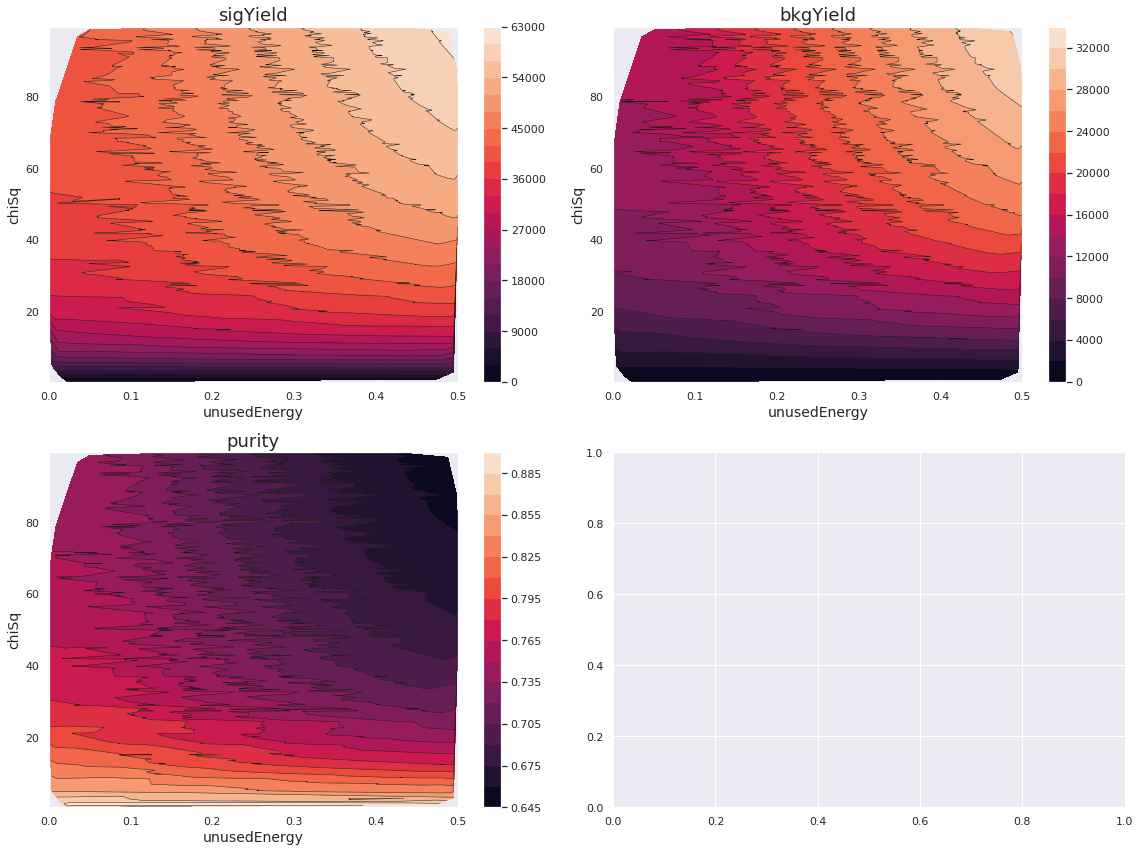

In [228]:
plotMesh(
    df_quality.unusedEnergyThresh,
    df_quality.chiSqThresh,
    [df_quality.sigYield,df_quality.bkgYield,df_quality.purity]
)